# 1.Introduction
The purpose of this Capstone Project is to help people in exploring better facilities around their neighborhood. It will help people making smart and efficient decision on selecting great neighborhood out of numbers of other neighborhoods in North York, Toranto.

Lots of people are migrating to various states of Canada and needed lots of research for good housing prices and reputated schools for their children. This project is for those people who are looking for better neighborhoods. For ease of accessing to Cafe, School, Super market, medical shops, grocery shops, mall, theatre, hospital, like minded people, etc.

This Capstone Project aim to create an analysis of features for a people migrating to Central Toranto to search a best neighborhood as a comparative analysis between neighborhoods. The features include median housing price and better school according to ratings, crime rates of that particular area, road connectivity, weather conditions, good management for emergency, water resources both freash and waste water and excrement conveyed in sewers and recreational facilities.

It will help people to get awareness of the area and neighborhood before moving to a new city, state, country or place for their work or to start a new fresh life.

# 2. Data Section
Data Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Will use Central Toranto dataset which we scrapped from wikipedia on Week 3. Dataset consisting of latitude and longitude, zip codes.

Foursquare API Data:
We will need data about different venues in different neighborhoods of that specific borough.
In order to gain that information we will use “Foursquare” locational information. Foursquare is a location data provider with information about all manner of venues and events within an area of interest. Such information includes venue names, locations, menus and even photos. As such, the foursquare location platform will be used as the sole data source since all the stated required information can be obtained through the API.

After finding the list of neighborhoods, we then connect to the Foursquare API to gather information about venues inside each and every neighborhood. For each neighborhood, we have chosen the radius to be 100 meter.

The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue as follows:

1. Neighborhood
2. Neighborhood Latitude
3. Neighborhood Longitude
4. Venue
5. Name of the venue e.g. the name of a store or restaurant
6. Venue Latitude
7. Venue Longitude
8. Venue Category

In [1]:
!pip install geocoder
!pip install folium

In [2]:

import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


# 3. Data Extraction and Cleaning

Using BeautifulSoup Scraping List of Postal Codes of Given Wikipedia Page. Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [3]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'lxml')

table = soup.find("table")
table

table_rows = table.tbody.find_all("tr")

table_rows
res = []
for tr in table_rows:
    td = tr.find_all("td")
    #print(td)
    #type(td)
    row = [tr.text for tr in td]
    #print(row)
    # Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
    if row != [] and row[1] != 'Not assigned\n':
        # If a cell has a borough but a "Not assigned" neighborhood, then the neighborhood will be the same as the borough.
        if 'Not assigned\n' in row[2]: 
            row[2] = row[1]
            a=row[0].replace('\n', ''),row[1].replace('\n', ''), row[2].replace('\n', '')
        res.append(row)

# Dataframe with 3 columns
df = pd.DataFrame(res, columns = ["PostalCode", "Borough", "Neighborhood"])
df["Neighborhood"] = df["Neighborhood"].str.replace("\n","")
df["Borough"] = df["Borough"].str.replace("\n","")
df["PostalCode"] = df["PostalCode"].str.replace("\n","")
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:

df.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M1W,North York,Downsview
freq,1,24,4


In [5]:
df = df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(", ".join).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [138]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['PostalCode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [6]:
df2 = df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(", ".join)

In [139]:
df_2.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M5E,North York,Downsview
freq,1,24,4


In [140]:
df_2.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [141]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M6G')

[43.668690000000026, -79.42070999999999]

In [142]:
# Retrieving Postal Code Co-ordinates
postal_codes = df['PostalCode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [143]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [11]:
df[df.PostalCode == 'M5G']

,PostalCode,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493


In [144]:
df_2.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G,Scarborough,Woburn,43.76812,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892
5,M1J,Scarborough,Scarborough Village,43.74446,-79.23117
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.72582,-79.26461
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.71289,-79.28506
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.72360,-79.23496
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.69510,-79.26466


In [145]:
address = 'North York, Toronto'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)


In [146]:
location

Location(North York, Toronto, Golden Horseshoe, Ontario, Canada, (43.7543263, -79.44911696639593, 0.0))

In [147]:
latitude_x = location.latitude
longitude_y= location.longitude
print('The geograpical coordinates are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinates are 43.7543263, -79.44911696639593.


In [126]:
map_Central = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Central)  
    
map_Central

In [148]:

# @hiddel_cell
CLIENT_ID = '-----' # my Foursquare ID
CLIENT_SECRET = '----' # my Foursquare Secret
VERSION = '20180605'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)



Your credentails:
CLIENT_ID: ----
CLIENT_SECRET: ----


In [149]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_x, 
   longitude_y, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [150]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc',
       'venue.location.neighborhood', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups'],
      dtype='object')

In [151]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# 4. Nearby Venues/Locations

In [152]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690
1,Wolfie's Deli,"[{'id': '4bf58dd8d48988d146941735', 'name': 'D...",43.754875,-79.442438
2,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.754767,-79.443250
3,Orly Restaurant & Grill,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",43.754493,-79.443507
4,Bagel Plus,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.755395,-79.440686


# 5. Categories of Nearby Venues/Locations

In [153]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
1,Wolfie's Deli,Deli / Bodega,43.754875,-79.442438
2,Tim Hortons,Coffee Shop,43.754767,-79.443250
3,Orly Restaurant & Grill,Middle Eastern Restaurant,43.754493,-79.443507
4,Bagel Plus,Restaurant,43.755395,-79.440686


In [133]:

# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Pizza Place                  2
Deli / Bodega                1
Bus Line                     1
Sushi Restaurant             1
Mediterranean Restaurant     1
Fried Chicken Joint          1
Middle Eastern Restaurant    1
American Restaurant          1
Restaurant                   1
Coffee Shop                  1
Name: categories, dtype: int64

In [154]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [135]:
# Nearby Venues
CentralTo_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [155]:
print('There are {} Uniques Categories.'.format(len(CentralTo_venues['Venue Category'].unique())))
CentralTo_venues.groupby('Neighborhood').count().head()

There are 312 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,25,25,25,25,25,25
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",13,13,13,13,13,13
Bayview Village,5,5,5,5,5,5
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24


# 6.One Hot Encoding of Features

In [156]:
# one hot encoding
CentralTo_onehot = pd.get_dummies(CentralTo_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
CentralTo_onehot['Neighborhood'] = CentralTo_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [CentralTo_onehot.columns[-1]] + list(CentralTo_onehot.columns[:-1])
CentralTo_onehot = CentralTo_onehot[fixed_columns]
CentralTo_grouped = CentralTo_onehot.groupby('Neighborhood').mean().reset_index()
CentralTo_onehot.head(5)

,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Newsagent,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,

In [100]:
num_top_venues = 5
for hood in CentralTo_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =CentralTo_grouped[CentralTo_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
              venue  freq
0     Shopping Mall  0.08
1    Cosmetics Shop  0.04
2            Bakery  0.04
3     Grocery Store  0.04
4  Sushi Restaurant  0.04


---- Alderwood, Long Branch ----
         venue  freq
0   Print Shop   0.1
1          Gym   0.1
2          Pub   0.1
3  Pizza Place   0.1
4  Coffee Shop   0.1


---- Bathurst Manor, Wilson Heights, Downsview North ----
                       venue  freq
0                Coffee Shop  0.15
1          Mobile Phone Shop  0.08
2                     Arcade  0.08
3        Fried Chicken Joint  0.08
4  Middle Eastern Restaurant  0.08


---- Bayview Village ----
              venue  freq
0       Flower Shop   0.2
1              Park   0.2
2             Trail   0.2
3       Gas Station   0.2
4  Asian Restaurant   0.2


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0  Italian Restaurant  0.08
1      Sandwich Place  0.08
2         Pizza Place  0.08
3         Coffee Shop  0.08
4   Indian Restaurant  

                venue  freq
0                Café  0.09
1         Coffee Shop  0.07
2         Pizza Place  0.05
3              Bakery  0.05
4  Falafel Restaurant  0.04


---- Runnymede, The Junction North ----
                    venue  freq
0                 Brewery  0.38
1                    Park  0.25
2  Furniture / Home Store  0.25
3      Athletics & Sports  0.12
4               Newsagent  0.00


---- Scarborough Village ----
                  venue  freq
0         Big Box Store  0.17
1     Indian Restaurant  0.17
2        Sandwich Place  0.17
3            Restaurant  0.17
4  Fast Food Restaurant  0.17


---- South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Beaumond Heights, Thistletown, Albion Gardens ----
                  venue  freq
0         Grocery Store  0.15
1  Fast Food Restaurant  0.08
2              Pharmacy  0.08
3  Caribbean Restaurant  0.08
4                  Park  0.08


---- St. James Town ----
                venue  freq
0         Coffee Shop  0.08
1

In [157]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Most Common venues near neighborhood

In [158]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = CentralTo_grouped['Neighborhood']

for ind in np.arange(CentralTo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(CentralTo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Pharmacy,Print Shop,Bubble Tea Shop,Skating Rink,Breakfast Spot,Shanghai Restaurant,Sandwich Place,Supermarket,Latin American Restaurant
1,"Alderwood, Long Branch",Sandwich Place,Pub,Performing Arts Venue,Gym,Coffee Shop,Pharmacy,Gas Station,Print Shop,Pizza Place,Convenience Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Sandwich Place,Arcade,Mediterranean Restaurant,Mobile Phone Shop,Fried Chicken Joint,Sushi Restaurant,Park,Restaurant,Middle Eastern Restaurant
3,Bayview Village,Flower Shop,Park,Asian Restaurant,Trail,Gas Station,Yoga Studio,Donut Shop,Eastern European Restaurant,Electronics Store,Elementary School
4,"Bedford Park, Lawrence Manor East",Pizza Place,Sandwich Place,Italian Restaurant,Coffee Shop,Butcher,Liquor Store,Juice Bar,Restaurant,Thai Restaurant,Sports Club


# K-Means Clustering Approach

In [159]:
# Using K-Means to cluster neighborhood into 3 clusters
CentralTo_grouped_clustering = CentralTo_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(CentralTo_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0])

In [193]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


ValueError: cannot insert Cluster Labels, already exists

In [224]:
CentralTo_merged =df.iloc[17:35,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
CentralTo_merged = CentralTo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

CentralTo_merged# check the last columns!
#df
df_2= CentralTo_merged['Neighborhood']

In [225]:
df_2

17                                  Hillcrest Village
18                       Fairview, Henry Farm, Oriole
19                                    Bayview Village
20                           York Mills, Silver Hills
21                            Willowdale, Newtonbrook
22                        Willowdale, Willowdale East
23                                    York Mills West
24                        Willowdale, Willowdale West
25                                          Parkwoods
26                                          Don Mills
27                                          Don Mills
28    Bathurst Manor, Wilson Heights, Downsview North
29                    Northwood Park, York University
30                                          Downsview
31                                          Downsview
32                                          Downsview
33                                          Downsview
34                                   Victoria Village
Name: Neighborhood, dtype: o

In [211]:
kclusters =2

# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(CentralTo_merged['Latitude'], CentralTo_merged['Longitude'], CentralTo_merged['Neighborhood'], CentralTo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters



In [194]:
df1=CentralTo_merged.loc[CentralTo_merged['Cluster Labels'] == 0,CentralTo_merged.columns[[2] + list(range(5, CentralTo_merged.shape[1]))]]
df2=CentralTo_merged.loc[CentralTo_merged['Cluster Labels'] == 1,CentralTo_merged.columns[[2] + list(range(5, CentralTo_merged.shape[1]))]]


In [214]:
df_2["Neighborhood"]

0                                         Malvern, Rouge
1                 Rouge Hill, Port Union, Highland Creek
2                      Guildwood, Morningside, West Hill
3                                                 Woburn
4                                              Cedarbrae
5                                    Scarborough Village
6            Kennedy Park, Ionview, East Birchmount Park
7                        Golden Mile, Clairlea, Oakridge
8        Cliffside, Cliffcrest, Scarborough Village West
9                            Birch Cliff, Cliffside West
10     Dorset Park, Wexford Heights, Scarborough Town...
11                                     Wexford, Maryvale
12                                             Agincourt
13               Clarks Corners, Tam O'Shanter, Sullivan
14     Milliken, Agincourt North, Steeles East, L'Amo...
15                         Steeles West, L'Amoreaux West
16                                           Upper Rouge
17                             

In [229]:
CentralTo_Avg_HousingPrice=pd.DataFrame({"Neighborhood":CentralTo_merged["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0
                                                              
                                                              
                                                              ]})

,Neighborhood,Cluster Labels,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Hillcrest Village,0,0,Park,Chinese Restaurant,Residential Building (Apartment / Condo),Pharmacy,Bakery,Yoga Studio,Escape Room,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
19,Bayview Village,0,0,Flower Shop,Park,Asian Restaurant,Trail,Gas Station,Yoga Studio,Donut Shop,Eastern European Restaurant,Electronics Store,Elementary School
20,"York Mills, Silver Hills",0,0,Concert Hall,Park,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space
25,Parkwoods,0,0,Park,Pet Store,Food & Drink Shop,Burger Joint,Yoga Studio,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant


In [196]:
df2

,Neighborhood,Cluster Labels,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,"Fairview, Henry Farm, Oriole",1,1,Clothing Store,Coffee Shop,Fast Food Restaurant,Women's Store,Juice Bar,Bakery,Toy / Game Store,Shoe Store,Bank,Cosmetics Shop
21,"Willowdale, Newtonbrook",1,1,Korean Restaurant,Middle Eastern Restaurant,Coffee Shop,Café,Hookah Bar,Pizza Place,Supermarket,Beer Store,Sandwich Place,Bank
22,"Willowdale, Willowdale East",1,1,Coffee Shop,Pizza Place,Japanese Restaurant,Ramen Restaurant,Café,Fast Food Restaurant,Sandwich Place,Sushi Restaurant,Fried Chicken Joint,Restaurant
23,York Mills West,1,1,Park,Coffee Shop,Restaurant,Metro Station,Food Court,Thai Restaurant,French Restaurant,Golf Course,Gym,Intersection
24,"Willowdale, Willowdale West",1,1,Pizza Place,Butcher,Grocery Store,Park,Pharmacy,Coffee Shop,Yoga Studio,Ethiopian Restaurant,Eastern European Restaurant,Electronics Store
26,Don Mills,1,1,Coffee Shop,Japanese Restaurant,Sandwich Place,Beer Store,Italian Restaurant,Bank,Intersection,Electronics Store,Restaurant,Supermarket
27,Don Mills,1,1,Coffee Shop,Japanese Restaurant,Sandwich Place,Beer Store,Italian Restaurant,Bank,Intersection,Electronics Store,Restaurant,Supermarket
28,"Bathurst Manor, Wilson Heights, Downsview North",1,1,Coffee Shop,Sandwich Place,Arcade,Mediterranean Restaurant,Mobile Phone Shop,Fried Chicken Joint,Sushi Restaurant,Park,Restaurant,Middle Eastern Restaurant
29,"Northwood Park, York University",1,1,Furniture / Home Store,Road,Fast Food Restaurant,Bank,Caribbean Restaurant,Miscellaneous Shop,Japanese Restaurant,Coffee Shop,Bar,Massage Studio
30,Downsview,1,1,Coffee Shop,Vietnamese Restaurant,Grocery Store,Park,Pizza Place,Fast Food Restaurant,Hotel,Turkish Restaurant,Sandwich Place,Shopping Mall


In [230]:
CentralTo_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

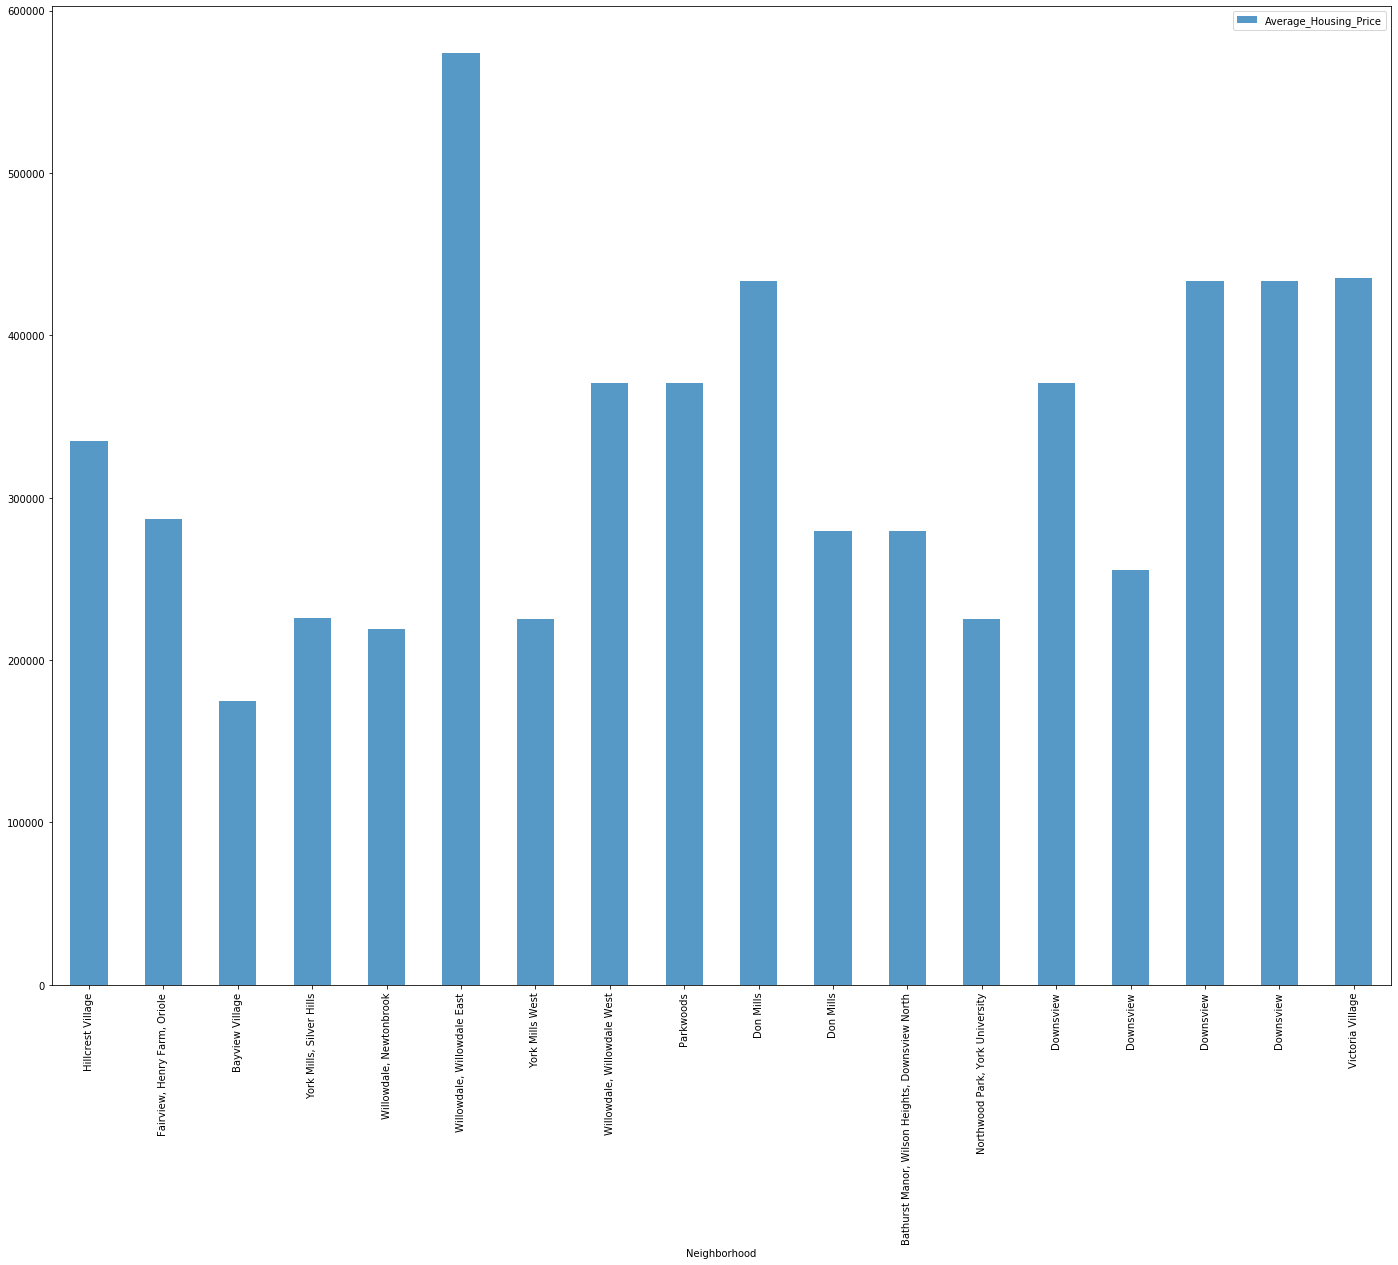

In [231]:
CentralTo_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

# School Rating by Clusters

In [232]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [234]:
new_CentralTo=CentralTo_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
CentralTo_school_ratings=pd.DataFrame({"Neighborhood":CentralTo_merged["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,
                                                           ]})

In [237]:
CentralTo_school_ratings.set_index(CentralTo_merged["Neighborhood"],inplace=True,drop=True)

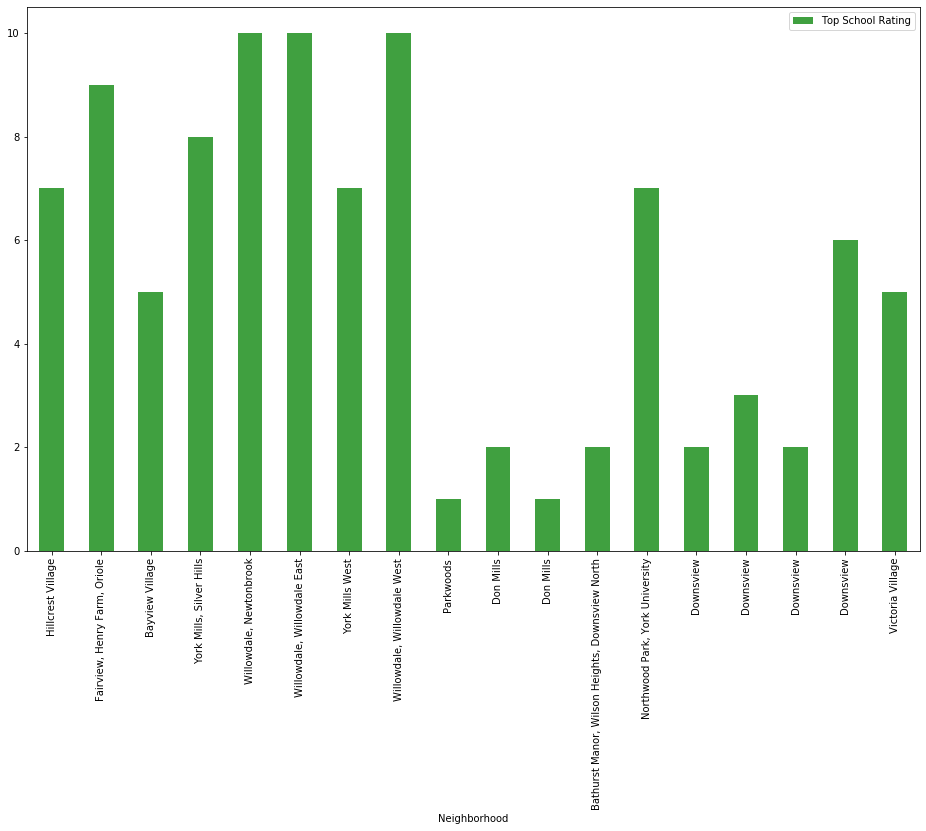

In [238]:
CentralTo_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);


Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.